# This jupyter notebook will be following the tutorial on Quantopian
##[Lesson 1 Introduction](https://www.quantopian.com/tutorials/getting-started)

In [1]:
# research environment functions
from quantopian.research import prices, symbols

# Pandas Library for data frame manipulation
import pandas as pd

[Moving Average](https://www.investopedia.com/terms/m/movingaverage.asp) 
widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random short-term price fluctuations

[Simple Moving Average](https://www.investopedia.com/terms/m/movingaverage.asp)
arithmetic moving average calculated by adding recent closing prices and then dividing that by the number of time periods in the calculation average

[Exponential Moving Average](https://www.investopedia.com/terms/e/ema.asp)type of moving average (MA) that places a greater weight and significance on the most recent data points

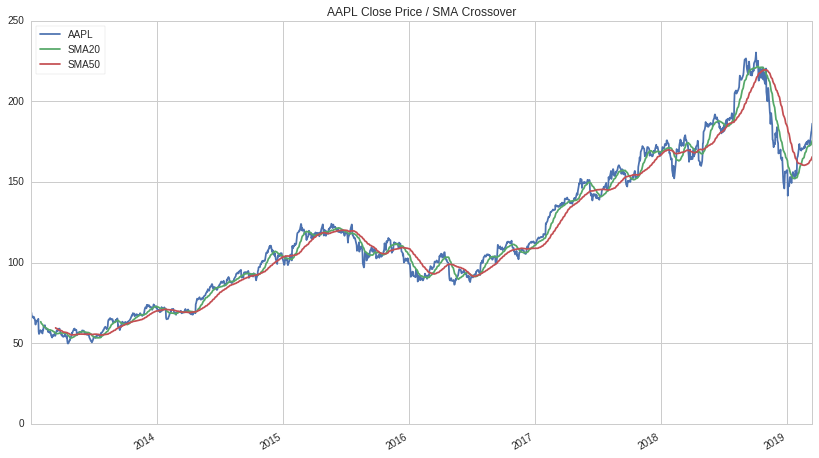

In [2]:
# Query historical pricing data for AAPL
aapl_close = prices(
    assets = symbols('AAPL'),
    start = '2013-01-01',
    end = '2019-03-15'
)

# Compute 20 and 50 day moving averages on AAPL's pricing data
aapl_sma20 = aapl_close.rolling(20).mean()
aapl_sma50 = aapl_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
pd.DataFrame({ 
    'AAPL': aapl_close,
    'SMA20': aapl_sma20,
    'SMA50': aapl_sma50
}).plot(
    title='AAPL Close Price / SMA Crossover'
);

## [Lesson 2 Data Exploration](https://www.quantopian.com/tutorials/getting-started#lesson2)

In [3]:
# using quantopian.research functions returns and symbols
from quantopian.research import returns # symbols imported above already

# select time period to inspect
period_start = '2018-01-01'
period_end = '2018-12-31'


# Query returns data for AAPL
aapl_returns = returns(
    assets=symbols('AAPL'),
    start=period_start,
    end=period_end
)

# display first 10 rows
aapl_returns.head(10)

2018-01-02 00:00:00+00:00    0.017422
2018-01-03 00:00:00+00:00   -0.000407
2018-01-04 00:00:00+00:00    0.004881
2018-01-05 00:00:00+00:00    0.011269
2018-01-08 00:00:00+00:00   -0.003602
2018-01-09 00:00:00+00:00   -0.000052
2018-01-10 00:00:00+00:00   -0.000518
2018-01-11 00:00:00+00:00    0.005971
2018-01-12 00:00:00+00:00    0.009126
2018-01-16 00:00:00+00:00   -0.003845
Freq: C, Name: Equity(24 [AAPL]), dtype: float64

Quantopian integrates a number of alternative datasets that include corporate fundamentals, stock sentiment analysis, and macroeconomic indicators, to name a few.

Our goal in this tutorial will be to build an algorithm that selects and trades assets based on sentiment data, so let's take a look at PsychSignal's [Stock Twits Trader Mood dataset](https://www.quantopian.com/data/psychsignal/stocktwits). 

We will query the data using Quantopian's Pipeline API, which is a powerful tool you will use over and over again to access and analyze data in Research.

In [4]:
# Pipeline imports
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data.psychsignal import stocktwits

# Pipeline definition
def make_pipeline():
    returns = Returns(window_length=2)
    sentiment = stocktwits.bull_minus_bear.latest
    msg_volume = stocktwits.total_scanned_messages.latest
    
    return Pipeline(
        columns={
            'daily_returns': returns,
            'sentiment': sentiment,
            'msg_volume': msg_volume
        },
    )


# pipeline execution - building a pipeline takes time, so best to avoid reruning it unnecessarily
data_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

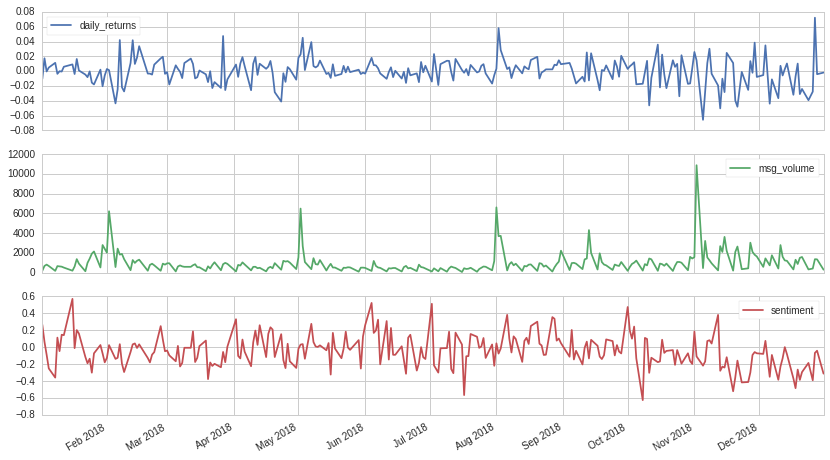

In [5]:
# Filter results for AAPL
aapl_output = data_output.xs(
    symbols('AAPL'),
    level=1
)


# Plot results for AAPL
aapl_output.plot(subplots=True);

## Lesson 3 [Pipeline API](https://www.quantopian.com/tutorials/getting-started#lesson3)

Pipeline API is powerful tool for [cross-sectional analysis](https://www.investopedia.com/terms/c/cross_sectional_analysis.asp) of asset data.

Pipeline API's common uses are:
1. selecting assests based on filtering rules
2. ranking assests based ona scoring function
3. calculatinr portfolio allocations

In [6]:
# pipeline class
from quantopian.pipeline import Pipeline

def make_pipeline():
    # Create and return an empty Pipeline | this will help us keep things organized as pipeline grows 
        # in complexity
    return Pipeline()

In [7]:
# To add an output to our pipeline we need to include a reference to a dataset, and specify
    # the computations we want to carry out on that data. For example, we will add a reference
    # to the close column from the USEquityPricing dataset. Then, we can define our output to be 
    # the latest value from this column as follows:
    
    
    
# Import Pipeline class and USEquityPricing Dataset
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing

def make_pipeline():
    # Get latest closing price
    close_price = USEquityPricing.close.latest
    
    # Return Pipeline containing latest closing price
    return Pipeline(
        columns={
            'close_price': close_price,
        }
    )

Pipeline API also provides # of built-in calculations, some of which are computed over trailing windows of data.

Example, following code imports Psychsignal's stocktwits dataset and defines output as 3 day moving average of its bull_minus_bear column.

In [8]:
# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits

# Import built-in oving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage


def make_pipeline():
    # get latest closing price
    close_price = USEquityPricing.close.latest
    
    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    
    # Return Pipeline containing close_price
    # and sentiment score
    return Pipeline(
        columns={
            'close_price': close_price,
            'sentiment_score': sentiment_score,
        },
    )

In [9]:
# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits

# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage

# Import built-in trading universe
from quantopian.pipeline.experimental import QTradableStocksUS


def make_pipeline():
    # Create a reference to our trading universe
    base_universe = QTradableStocksUS()

    # Get latest closing price
    close_price = USEquityPricing.close.latest

    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Return Pipeline containing close_price and
    # sentiment_score that has our trading universe as screen
    return Pipeline(
        columns={
            'close_price': close_price,
            'sentiment_score': sentiment_score,
        },
        screen=base_universe,
    )

Execute pipeline definition over a specific period of time using run_pipeline.
Output will be pandas DataFrame indexed by date and asset, with columns corresponding to outputs we added to our pipeline definition:


In [10]:
# Execute pipeline created by make_pipeline
# between start_date and end_date
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2018-01-01',
    end_date='2018-12-31'
)

# Display last 10 rows
pipeline_output.tail(10)

close_price  sentiment_score
2018-12-31 00:00:00+00:00 Equity(51722 [HUD])           16.84         0.000000
                          Equity(51725 [FTSI])           6.95         0.106667
                          Equity(51734 [VICI])          18.56        -0.666667
                          Equity(51742 [WHD])           27.25        -1.000000
                          Equity(51806 [CRON])          10.40         0.269572
                          Equity(51815 [GLIB_A])        41.15              NaN
                          Equity(51832 [ZS])            39.80         0.434000
                          Equity(51854 [DBX])           20.79        -0.380000
                          Equity(51895 [SPOT])         112.10         0.327778
                          Equity(51917 [ZUO])           17.66        -0.574000

## [Lesson 4 Strategy Analysis](https://www.quantopian.com/tutorials/getting-started#lesson4)
- first code snippet of this sectin was completed above
- analyze the top 350 and bottom 350 stocks ranked by sentiment_score
- create pipeline filters for these sets using the top and bottom methods of our sentiment_score output, and combine them using the | operator to get their union
- remove anything outside of our tradable universe by using the & operator to get the intersection between our filter and our universe

In [11]:
# pipeline imports 
def make_pipeline():
    base_universe = QTradableStocksUS()
    
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length = 3,
    )
    
    # Create filter for top 350 and bottom 350 
    # assets based on their sentiment scores
    top_bottom_scores = (
        sentiment_score.top(350) | sentiment_score.bottom(350)
    )
    
    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        # Set screen as the intersecti between our filter
        # and trading universe
        
        screen=(
            base_universe & top_bottom_scores
        )
    )

In [12]:
# specify a time range to evaluate
period_start = '2018-01-01'
period_end = '2018-12-31'

# Execute pipeline over evauation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In [13]:
# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Querey pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

- factor analysis tool, [Alphalens](https://www.quantopian.com/lectures/factor-analysis-with-alphalens), to test the quality of our selection strategy
- function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods
- will separate our factor data into 2 quantiles (the top and bottom half), and use 1, 5 and 10 day holding periods

In [14]:
# import alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['sentiment_score'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10)
)

# Display first 5 rows
factor_data.head(5)

Dropped 3.0% entries from factor data: 3.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                              
2018-01-02 00:00:00+00:00 Equity(52 [ABM])    0.003843  0.051506  0.031261   
                          Equity(67 [ADSK])   0.021102  0.046685  0.055089   
                          Equity(289 [MATX]) -0.046663 -0.002585 -0.001624   
                          Equity(300 [ALK])  -0.004530 -0.049338 -0.055595   
                          Equity(460 [APD])   0.005261  0.021577  0.018254   

                                                factor  factor_quantile  
date                      asset                                          
2018-01-02 00:00:00+00:00 Equity(52 [ABM])    1.603333                2  
                          Equity(67 [ADSK])   1.596667                2  
                          Equity(289 [MATX]) -1.670000                1  
                          Equity(300 [ALK])   1.676667                2  
                          Equity(460 [APD])   1.771667                2

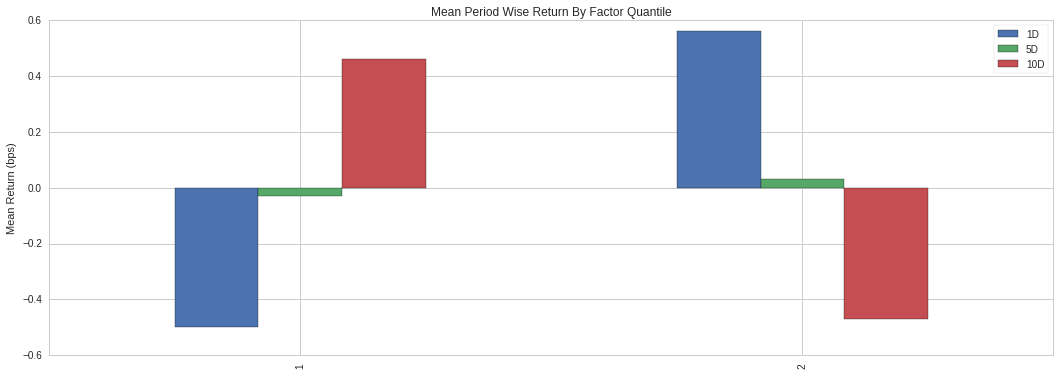

In [15]:
# calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluations time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
)

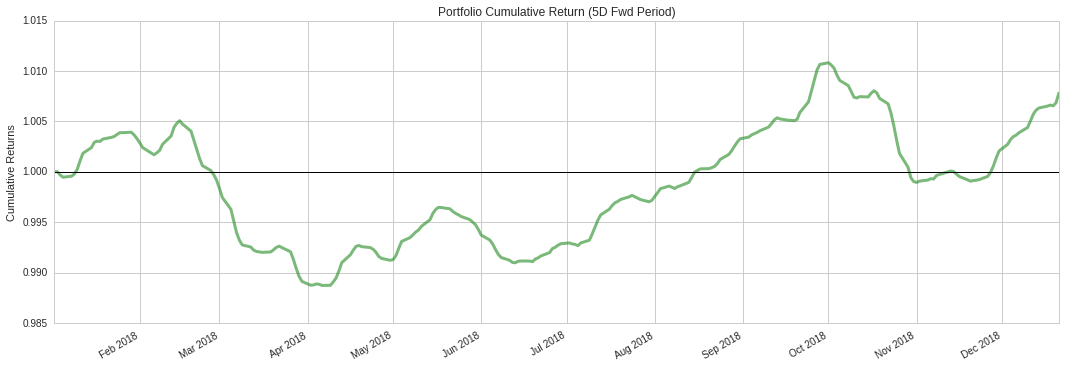

In [16]:
# plot cumulative returns of a factor-weighted long-short portfolio with a 5 ay holding period

#calculate factor_weighted long-short portfolo returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D', freq=pd.tseries.offsets.BDay())